In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Load Data 

In [2]:
df = pd.read_csv('adult_reconstruction.csv')

# Check for Missing Values

In [3]:
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

#### There are some cells with ? in it, so we replace with nans and check the percentage of missing values.

In [4]:
df.isin(['?']).sum()

hours-per-week       0
age                  0
capital-gain         0
capital-loss         0
workclass         2859
education            0
education-num        0
marital-status       0
relationship         0
race                 0
gender               0
native-country     859
income               0
occupation        2869
dtype: int64

In [5]:
df['workclass'] = df['workclass'].replace('?', np.nan)
df['occupation'] = df['occupation'].replace('?', np.nan)
df['native-country'] = df['native-country'].replace('?', np.nan)


In [6]:
perc1 = df['workclass'].isnull().sum()/len(df['workclass'])*100
perc2 = df['occupation'].isnull().sum()/len(df['occupation'])*100
perc3 = df['native-country'].isnull().sum()/len(df['native-country'])*100
print("Percentage of the data missing = ", perc1,"%, ", perc2,"%, ", perc3,'%')


Percentage of the data missing =  5.7721426985120425 %,  5.792332074862207 %,  1.7342674284791342 %


In [7]:
df.dropna(how='any', inplace=True)
df.isnull().sum()

hours-per-week    0
age               0
capital-gain      0
capital-loss      0
workclass         0
education         0
education-num     0
marital-status    0
relationship      0
race              0
gender            0
native-country    0
income            0
occupation        0
dtype: int64

In [8]:
## Check if there are any duplicate rows
df.duplicated().sum()

208

In [9]:
df = df.drop_duplicates()

# Analyze Data

In [10]:
print(df.shape)
df.describe()

(45641, 14)


,hours-per-week,age,capital-gain,capital-loss,education-num,income
count,45641.000000,45641.000000,45641.000000,45641.000000,45641.00000,45641.000000
mean,40.915120,38.487566,1080.570759,87.546307,10.10438,34417.740606
std,11.966191,13.211451,7426.000706,402.596785,2.54683,26870.885616
min,1.000000,17.000000,0.000000,0.000000,1.00000,107.000000
25%,40.000000,28.000000,0.000000,0.000000,9.00000,13200.000000
50%,40.000000,37.000000,0.000000,0.000000,10.00000,27260.000000
75%,45.000000,47.000000,0.000000,0.000000,12.00000,49515.000000
max,99.000000,90.000000,99999.000000,4356.000000,16.00000,99999.000000


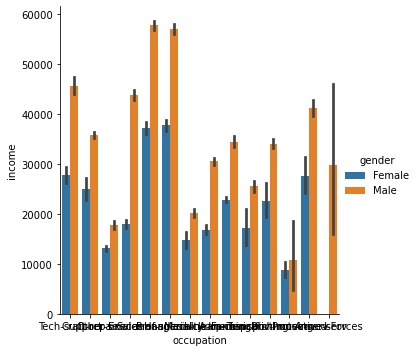

In [20]:
## EDA HERE 
## cat plot of occupation and gender
## we need to show the x label better maybe with numbers
sns.catplot(data=df, kind="bar", x="occupation", y="income", hue="gender")

<AxesSubplot:xlabel='income', ylabel='Count'>

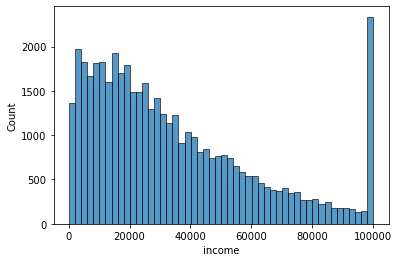

In [22]:
sns.histplot(df['income'])

<AxesSubplot:xlabel='age', ylabel='Count'>

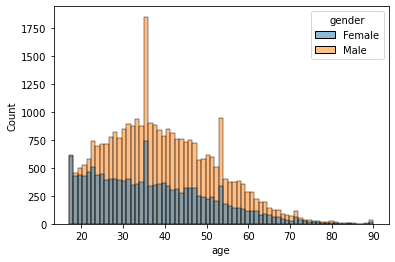

In [17]:
sns.histplot(data=df, x="age", hue="gender")

<AxesSubplot:xlabel='income', ylabel='Count'>

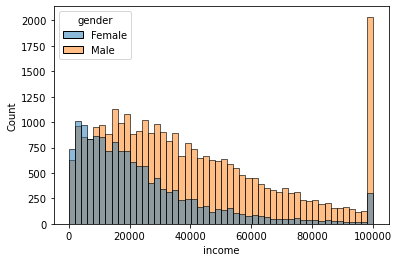

In [19]:
sns.histplot(data=df, x="income", hue="gender")

### Check for Outliers

In [21]:
### remove some extreme cases here hehe

### Decode categorical data

###### Create dummy values for all categorical data

In [15]:
to_drop = ["workclass", "education", "marital-status", "relationship", "race", "native-country", "occupation", "gender"]
dummy_vars = pd.get_dummies(df[to_drop])
dfWithDummy = pd.concat([df.drop(to_drop, axis=1), dummy_vars], axis = 1)
dfWithDummy.head()

,hours-per-week,age,capital-gain,capital-loss,education-num,income,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,gender_Female,gender_Male
0,20,40,0,0,13,49100,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,40,21,0,0,10,11500,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,10,17,0,0,7,2600,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,50,51,0,0,9,38997,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
5,38,26,0,1876,13,38524,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
